**ANALYZING FACTOR OF PRODUCTION FOR THEIR IMPACT ON GDP**

## Objective:
This analysis explores how private and public investment (P_stock & G_stock) interact with a working population(work_popn), which is the factor of productions in standard Cobb-Douglas Equation, influences GDP. We use different models and compare their results.

- **Linear Regression** for interpretability between the factors of Production and GDP.
- **Log-Linear Regression** for reflecting CoBB-Douglas Production Function.
- **Log-Linear Regression with Country and Decade Parameter** for time and country effect.
- **Random Forest Regression** for predictive modeling and  **SHAP values** to interpret feature importance.

## Key Research Questions:
1. Does **private investment** drive GDP more than **government investment**?
2. Do **public-private investments complement each other**, or substitute each other?



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import  r2_score, root_mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay

In [5]:
# !pip install shap

In [15]:
# # Load dataset
# file_path = r"C:\Users\Sushil\Desktop\STAT\WORLD_data.csv"
# df= pd.read_csv(file_path)
# df["Work_ popn"] = df["Work_popn"]*2080/1000000000 #2080 working hour per year converted to billion-h
# df = df.dropna(axis=0, how="all")
# df= df.dropna(axis=1, how="all")
# df=df.drop(["Work_popn"], axis=1)

# # Save DataFrame as a pickle file
# df.to_pickle("world_data.pkl")
# print (df.head())


   country  year  G_stock  P_stock   GDP  population  Work_ popn
0  Albania  1970     3.35     4.89  8.10     1150954    2.393984
1  Albania  1971     3.48     5.06  8.42     1187511    2.470023
2  Albania  1972     3.61     5.25  8.76     1225713    2.549483
3  Albania  1973     3.75     5.43  9.11     1263871    2.628852
4  Albania  1974     3.90     5.62  9.48     1303917    2.712147


In [17]:
# Load Dataframe from pickle file
df_memory = pd.read_pickle("world_data.pkl")
df =df_memory
print (df.head())


   country  year  G_stock  P_stock   GDP  population  Work_ popn
0  Albania  1970     3.35     4.89  8.10     1150954    2.393984
1  Albania  1971     3.48     5.06  8.42     1187511    2.470023
2  Albania  1972     3.61     5.25  8.76     1225713    2.549483
3  Albania  1973     3.75     5.43  9.11     1263871    2.628852
4  Albania  1974     3.90     5.62  9.48     1303917    2.712147


In [19]:
df=df.dropna(axis=0)
na_per_column =df.isna().sum()
total_na = df.isna().sum().sum()
print(na_per_column)
print("Total NA values:", total_na)

country       0
year          0
G_stock       0
P_stock       0
GDP           0
population    0
Work_ popn    0
dtype: int64
Total NA values: 0


In [21]:
X = df[["G_stock", "P_stock", "Work_ popn"]]
y = df["GDP"]

In [23]:
X_train, X_test, y_train, y_test = train_test_split ( X, y, test_size = 0.2, random_state= 42)

In [25]:
# Initialize and train the Linear model
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [27]:
coefficients = model.coef_  
intercept = model.intercept_  


print("Intercept (a):", intercept)
print("\nFeature Coefficients:")
for feature, coef in zip(X_train.columns, coefficients):
    print(f"{feature}: {coef:.4f}")

linear_equation = f"Y = {intercept:.4f}"
for feature, coef in zip(X_train.columns, coefficients):
    linear_equation += f" + ({coef:.4f} * {feature})"

print("\nLinear Regression Equation:")
print(linear_equation)

Intercept (a): -11.300002418247914

Feature Coefficients:
G_stock: 0.3114
P_stock: 0.4752
Work_ popn: 0.8098

Linear Regression Equation:
Y = -11.3000 + (0.3114 * G_stock) + (0.4752 * P_stock) + (0.8098 * Work_ popn)


In [29]:
# Compute evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2 Score): {r2:.4f}")

Mean Absolute Error (MAE): 66.7965
Root Mean Squared Error (RMSE): 189.8788
R-squared (R2 Score): 0.9822


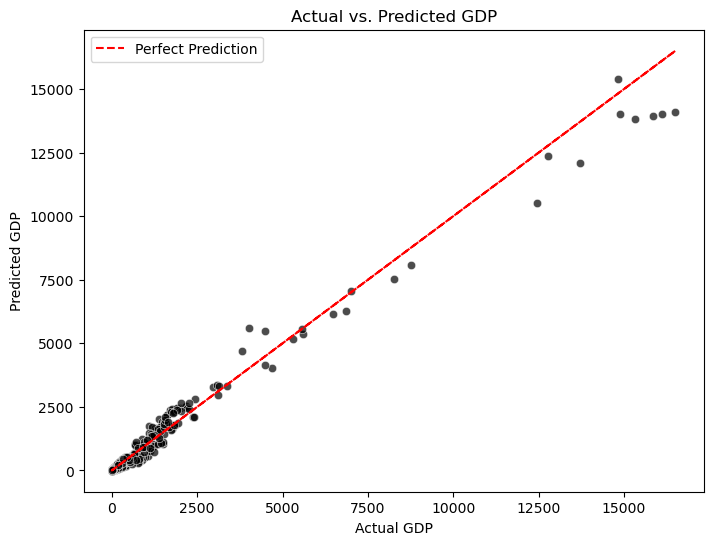

In [31]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, color="black", alpha=0.7)
plt.plot(y_test, y_test, color="red", linestyle="dashed", label="Perfect Prediction")
plt.xlabel("Actual GDP")
plt.ylabel("Predicted GDP")
plt.title("Actual vs. Predicted GDP")
plt.legend()
plt.show()


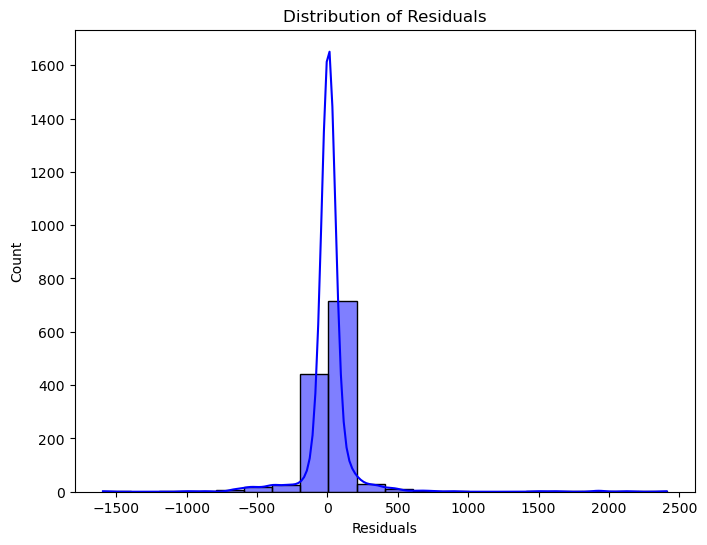

In [33]:
residuals = y_test - y_pred

plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=20, kde=True, color="blue")
plt.xlabel("Residuals")
plt.title("Distribution of Residuals")
plt.show()


**LOG TRANSFORMATION**

In [35]:
df_log = df.copy()
exclude_columns = ["country", "year", "population"]
transform_columns = [column for column in df.columns if column not in exclude_columns]
df_log[transform_columns] = np.log(df_log[transform_columns])
print(df_log.head())
                                   

   country  year   G_stock   P_stock       GDP  population  Work_ popn
0  Albania  1970  1.208960  1.587192  2.091864     1150954    0.872959
1  Albania  1971  1.247032  1.621366  2.130610     1187511    0.904227
2  Albania  1972  1.283708  1.658228  2.170196     1225713    0.935891
3  Albania  1973  1.321756  1.691939  2.209373     1263871    0.966547
4  Albania  1974  1.360977  1.726332  2.249184     1303917    0.997741


In [45]:
features =["G_stock", "P_stock", "Work_ popn"]
X_log= df_log[features].values
y_log=df_log.iloc[:, -3].values

print("Class Distribution:\n", df_log.iloc[:, -3].value_counts())

Class Distribution:
 GDP
-0.798508    10
-0.494296    10
-1.272966    10
-0.693147     8
-1.139434     8
             ..
 4.536784     1
 4.565077     1
 4.605870     1
 4.635117     1
 3.247658     1
Name: count, Length: 4913, dtype: int64


In [47]:
# Split dataset into training 80-20
X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [49]:
#model = Linear
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


In [51]:
feature_names = list(df.drop(columns=['country', 'year','GDP', 'population']).columns)
coefficients = model.coef_  
intercept = model.intercept_  

print("Intercept (a):", intercept)
print("\nFeature Coefficients:")
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef:.4f}")

linear_equation = f"Y = {intercept:.4f}"
for feature, coef in zip(feature_names, coefficients):
    linear_equation += f" + ({coef:.4f} * {feature})"

print("\nLinear Regression Equation:")
print(linear_equation)

Intercept (a): 3.7508190053574055

Feature Coefficients:
G_stock: 0.5649
P_stock: 1.2791
Work_ popn: 0.5016

Linear Regression Equation:
Y = 3.7508 + (0.5649 * G_stock) + (1.2791 * P_stock) + (0.5016 * Work_ popn)


In [53]:
# Convert intercept from log-scale
A = np.exp(intercept)  

# Print log-linear form
print("\nLog-Linear Model Equation:")
log_linear_equation = f"Y = {A:.4f}"
for feature, coef in zip(feature_names, coefficients):
    log_linear_equation += f" * {feature}^{coef:.4f}"

print(log_linear_equation)



Log-Linear Model Equation:
Y = 42.5559 * G_stock^0.5649 * P_stock^1.2791 * Work_ popn^0.5016


In [55]:
# Compute evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2 Score): {r2:.4f}")

Mean Absolute Error (MAE): 0.3136
Root Mean Squared Error (RMSE): 0.4216
R-squared (R2 Score): 0.9660


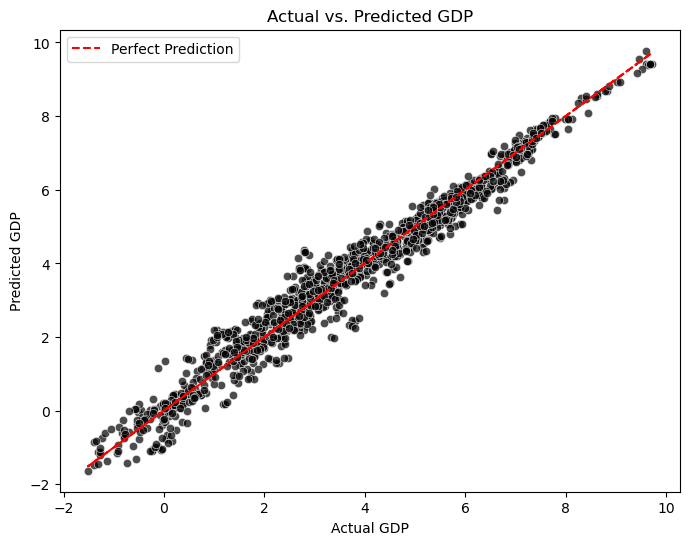

In [57]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, color="black", alpha=0.7)
plt.plot(y_test, y_test, color="red", linestyle="dashed", label="Perfect Prediction")
plt.xlabel("Actual GDP")
plt.ylabel("Predicted GDP")
plt.title("Actual vs. Predicted GDP")
plt.legend()
plt.show()


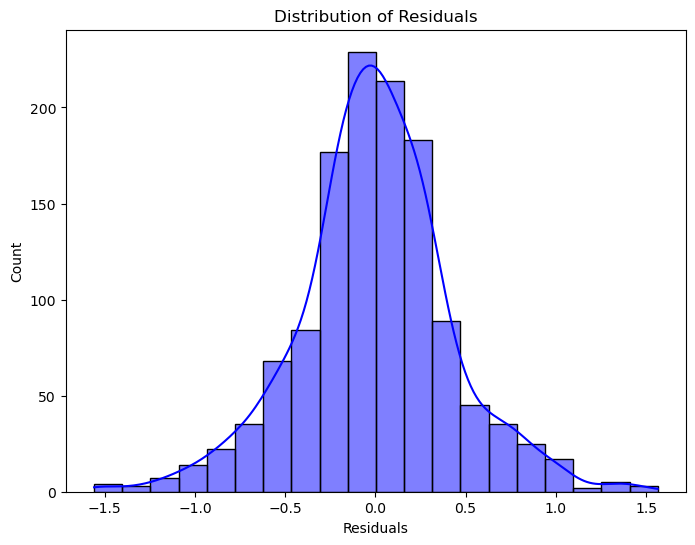

In [59]:
residuals = y_test - y_pred

plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=20, kde=True, color="blue")
plt.xlabel("Residuals")
plt.title("Distribution of Residuals")
plt.show()


**LOG TRANSFORMED WITH BOTH COUNTRY AND TIME AS VARIABLES**

In [61]:
df_log_encoded = df_log.copy()

# One-hot encode 'country' 
df_log_encoded = pd.get_dummies(df_log_encoded, columns=['country'], drop_first=False)
# df_log_encoded = df_log_encoded.drop(columns=['country_Nepal'])  # Nepal as the reference 

# Convert year into decades 
df_log_encoded['decade'] = (df_log_encoded['year'] // 10) * 10

df_log_encoded = pd.get_dummies(df_log_encoded, columns=['decade'], drop_first= False)

# Drop original 'year' column 
df_log_encoded = df_log_encoded.drop(columns=['year'])

# Define features and target variable
X_log = df_log_encoded.drop(columns=['GDP', 'population'])  # Features
y_log = df_log_encoded['GDP']  # Target variable

# Display dataset 
print(X_log.head())


    G_stock   P_stock  Work_ popn  country_Albania  country_Algeria  \
0  1.208960  1.587192    0.872959             True            False   
1  1.247032  1.621366    0.904227             True            False   
2  1.283708  1.658228    0.935891             True            False   
3  1.321756  1.691939    0.966547             True            False   
4  1.360977  1.726332    0.997741             True            False   

   country_Angola  country_Antigua and Barbuda  country_Argentina  \
0           False                        False              False   
1           False                        False              False   
2           False                        False              False   
3           False                        False              False   
4           False                        False              False   

   country_Australia  country_Austria  ...  country_Uruguay  \
0              False            False  ...            False   
1              False            

In [63]:
# Split 80-20
X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, test_size=0.2, random_state=42)

# Standardize numerical features 
numeric_cols = ["G_stock", "P_stock", "Work_ popn"]  # Excluding one-hot encoded country columns
decade_cols = [col for col in X_log.columns if col.startswith("decade_")]
numeric_cols.extend(decade_cols)  

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


In [65]:
model = LinearRegression()
model.fit(X_train, y_train)

# Predict values on test data
y_pred = model.predict(X_test)

In [67]:

feature_names = list(df_log_encoded.drop(columns=['GDP', 'population']).columns)  
coefficients = model.coef_
intercept = model.intercept_

print("Intercept (a):", intercept)
print("\nFeature Coefficients:")
for feature, coef in zip(feature_names, coefficients): 
    print(f"{feature}: {coef:.4f}")

# # Construct the linear regression equation
# linear_equation = f"Y = {intercept:.4f}"
# for feature, coef in zip(feature_names, coefficients):  
#     linear_equation += f" + ({coef:.4f} * {feature})"

# print("\nLinear Regression Equation:")
# print(linear_equation)


Intercept (a): 41411847.3898323

Feature Coefficients:
G_stock: 0.5288
P_stock: 0.8093
Work_ popn: 0.6157
country_Albania: -41411843.6970
country_Algeria: -41411843.3801
country_Angola: -41411843.9061
country_Antigua and Barbuda: -41411843.9275
country_Argentina: -41411842.9634
country_Australia: -41411842.7532
country_Austria: -41411843.2358
country_Bahamas, The: -41411843.1337
country_Bahrain: -41411843.3066
country_Bangladesh: -41411843.6243
country_Barbados: -41411844.3058
country_Belgium: -41411843.1551
country_Belize: -41411844.2031
country_Benin: -41411844.4950
country_Bhutan: -41411844.5959
country_Bolivia: -41411843.6691
country_Botswana: -41411843.9853
country_Brazil: -41411843.0706
country_Bulgaria: -41411843.1952
country_Burkina Faso: -41411844.2630
country_Burundi: -41411844.2674
country_Cabo Verde: -41411844.5372
country_Cambodia: -41411843.9841
country_Cameroon: -41411843.7661
country_Canada: -41411842.8512
country_Central African Republic: -41411844.9498
country_Chad: -

In [606]:
# # Compute the transformed intercept (A = e^intercept)
# A = np.exp(intercept)

# # Construct the log-linear equation
# log_linear_equation = f"Y = {A:.4f}"

# for feature, coef in zip(feature_names, coefficients):
#     if "country" in feature or "decade" in feature:
#         # Exponential transformation for categorical variables
#         log_linear_equation += f" * e^({coef:.4f} * {feature})"
#     else:
#         # Power transformation for continuous variables
#         log_linear_equation += f" * {feature}^{coef:.4f}"

# print("\nLog-Linear Model Equation:")
# print(log_linear_equation)

In [69]:
# Compute evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2 Score): {r2:.4f}")

Mean Absolute Error (MAE): 0.1427
Root Mean Squared Error (RMSE): 0.2015
R-squared (R2 Score): 0.9922


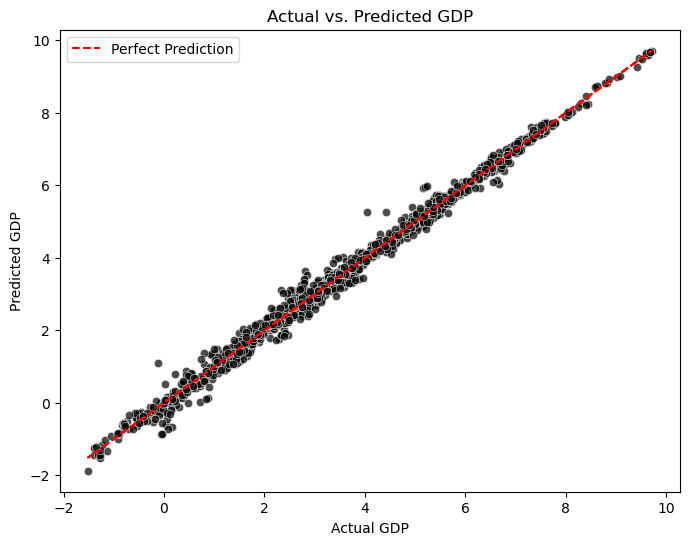

In [71]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, color="black", alpha=0.7)
plt.plot(y_test, y_test, color="red", linestyle="dashed", label="Perfect Prediction")
plt.xlabel("Actual GDP")
plt.ylabel("Predicted GDP")
plt.title("Actual vs. Predicted GDP")
plt.legend()
plt.show()

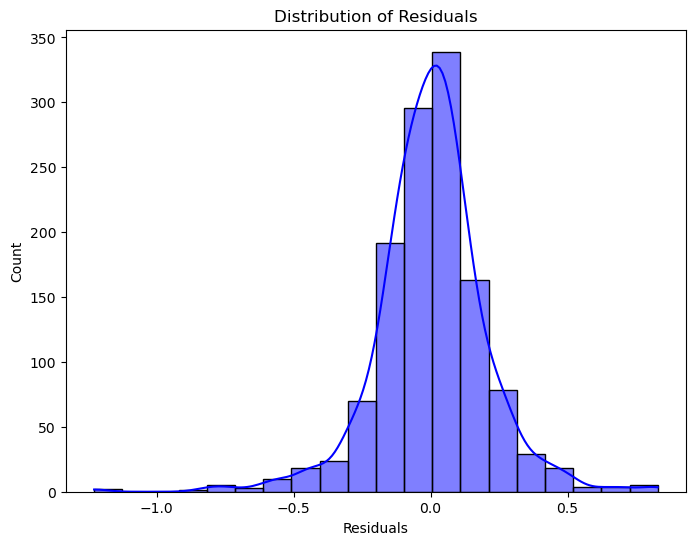

In [73]:
residuals = y_test - y_pred

plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=20, kde=True, color="blue")
plt.xlabel("Residuals")
plt.title("Distribution of Residuals")
plt.show()


**RANDOM FOREST**

In [75]:
df_rf = df.copy()

log_features = ["G_stock", "P_stock", "Work_ popn", "GDP"]
for col in log_features:
    df_rf[col] = np.log(df_rf[col] + 0.001) 
    
# One-hot encode 'country'
df_rf = pd.get_dummies(df_rf, columns=['country'], drop_first=False)

# Convert 'year' into decades
df_rf['decade'] = (df_rf['year'] // 10) * 10

# Drop original 'year' column 
df_rf = df_rf.drop(columns=['year'])

# One-hot encode 'decade'
df_rf = pd.get_dummies(df_rf, columns=['decade'], drop_first=False)

# Define features and target variable
X_rf = df_rf.drop(columns=['GDP', 'population'])  # Features
y_rf = df_rf['GDP']  # Target variable 

# Display dataset 
print(X_rf.head())


    G_stock   P_stock  Work_ popn  country_Albania  country_Algeria  \
0  1.209259  1.587397    0.873377             True            False   
1  1.247320  1.621564    0.904632             True            False   
2  1.283985  1.658419    0.936283             True            False   
3  1.322022  1.692123    0.966927             True            False   
4  1.361233  1.726510    0.998109             True            False   

   country_Angola  country_Antigua and Barbuda  country_Argentina  \
0           False                        False              False   
1           False                        False              False   
2           False                        False              False   
3           False                        False              False   
4           False                        False              False   

   country_Australia  country_Austria  ...  country_Uruguay  \
0              False            False  ...            False   
1              False            

In [77]:
# Split 80-20
X_train, X_test, y_train, y_test = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)


In [79]:
# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=200,max_depth =10, random_state=42)
rf_model.fit(X_train, y_train)

# Predict values on test data
y_pred = rf_model.predict(X_test)

In [80]:
# Compute evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2 Score): {r2:.4f}")

Mean Absolute Error (MAE): 0.1159
Root Mean Squared Error (RMSE): 0.1576
R-squared (R2 Score): 0.9952


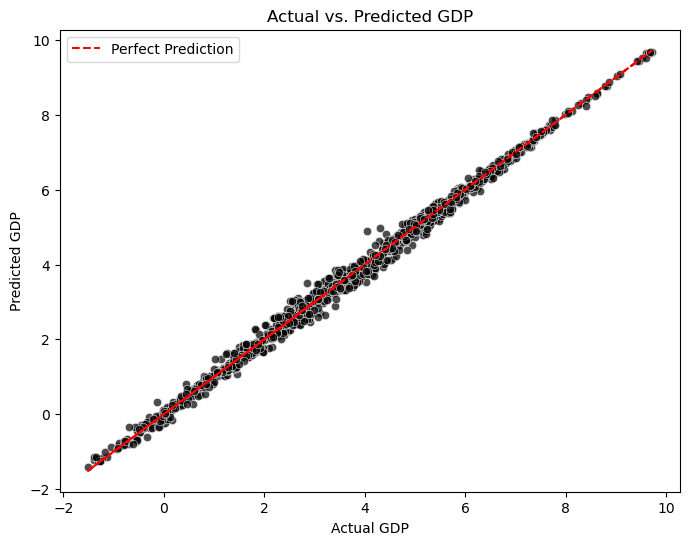

In [83]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, color="black", alpha=0.7)
plt.plot(y_test, y_test, color="red", linestyle="dashed", label="Perfect Prediction")
plt.xlabel("Actual GDP")
plt.ylabel("Predicted GDP")
plt.title("Actual vs. Predicted GDP")
plt.legend()
plt.show()

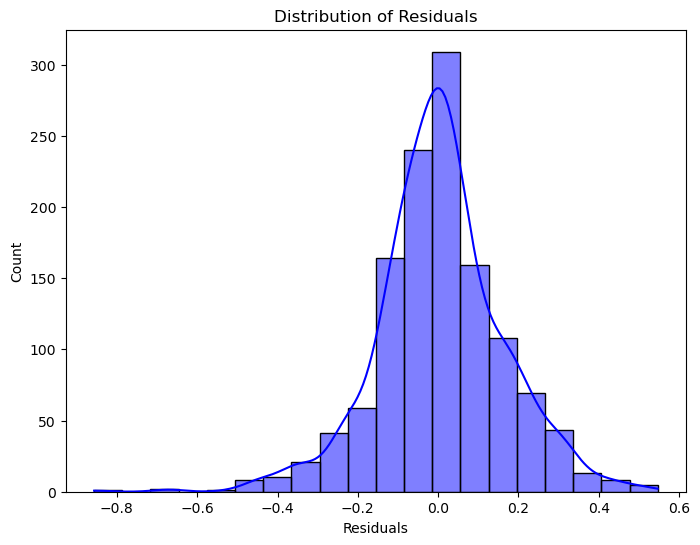

In [85]:
residuals = y_test - y_pred

plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=20, kde=True, color="blue")
plt.xlabel("Residuals")
plt.title("Distribution of Residuals")
plt.show()


In [87]:
# Extract feature importance 
feature_importances = rf_model.feature_importances_

# Normalize importance
feature_importances_normalized = feature_importances / feature_importances.sum()

# Create a DataFrame 
coefficients_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance (Approx. Coefficient)': feature_importances_normalized
}).sort_values(by='Importance (Approx. Coefficient)', ascending=False)

# Display the DataFrame 
coefficients_df['Importance (Approx. Coefficient)'] = coefficients_df['Importance (Approx. Coefficient)'].apply(lambda x: f"{x:.6f}")
print("\nRandom Forest Approximate Coefficients:")
print(coefficients_df.to_string(index=False))



Random Forest Approximate Coefficients:
                               Feature Importance (Approx. Coefficient)
                               P_stock                         0.845853
                               G_stock                         0.094818
                            Work_ popn                         0.046984
                           decade_1970                         0.000717
                        country_Zambia                         0.000711
                       country_Liberia                         0.000690
                          country_Oman                         0.000613
                         country_Sudan                         0.000592
                      country_Bulgaria                         0.000569
                           decade_1990                         0.000502
                    country_Madagascar                         0.000440
                      country_Ethiopia                         0.000393
                       

Top 6 features by importance:
P_stock            0.845853
G_stock            0.094818
Work_ popn         0.046984
decade_1970        0.000717
country_Zambia     0.000711
country_Liberia    0.000690
dtype: float64


C:\Users\Sushil\AppData\Local\Temp\ipykernel_1244\2447206815.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top6_features.values, y=top6_features.index, palette="viridis")


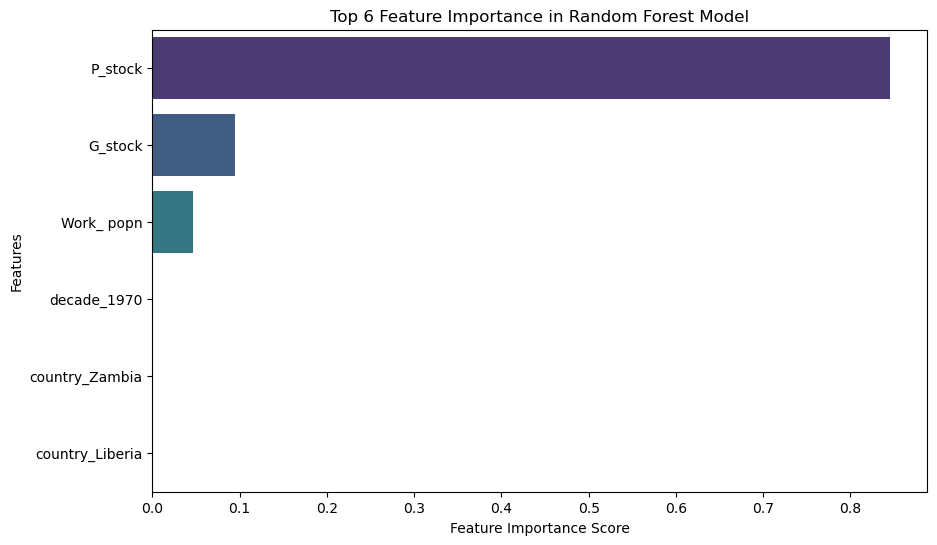

In [89]:
feature_importances_series = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Extract the top 6 features
top6_features = feature_importances_series.head(6)
print("Top 6 features by importance:")
print(top6_features)

# Plot only the top 6 features
plt.figure(figsize=(10, 6))
sns.barplot(x=top6_features.values, y=top6_features.index, palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Top 6 Feature Importance in Random Forest Model")
plt.show()

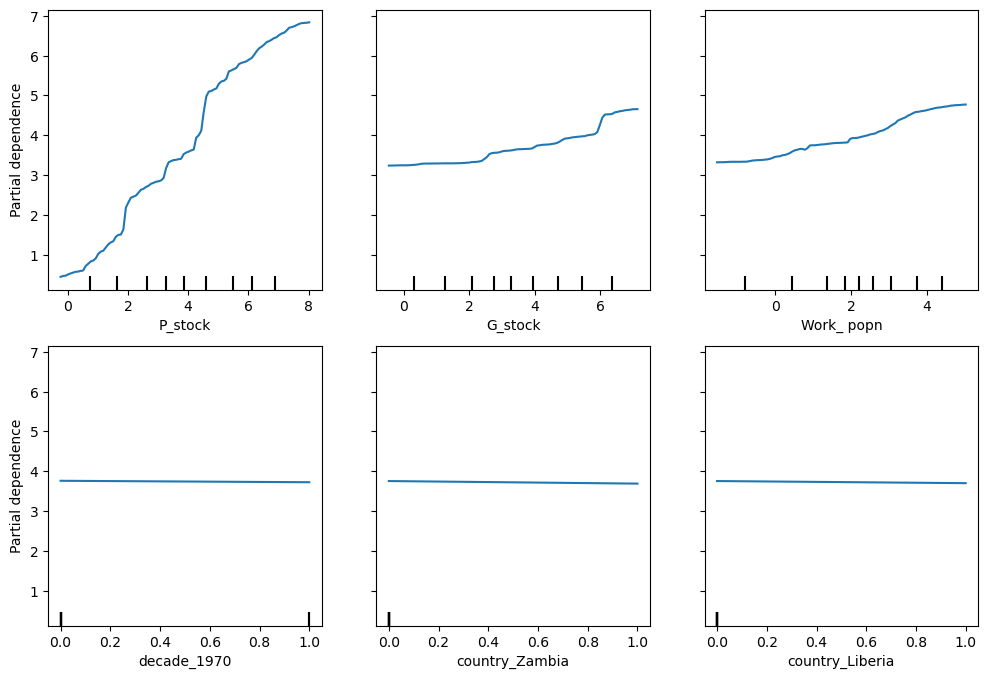

In [93]:
# Select top features for PDP visualization
top_features = coefficients_df['Feature'].head(6).tolist()

# Plot Partial Dependence Plots (PDPs) 
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(rf_model, X_train, features=top_features, ax=ax)
plt.show()


In [95]:
# Convert all columns in X_train to numeric 
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

print("Non-numeric columns:", X_train.select_dtypes(include=['O']).columns.tolist())


Non-numeric columns: []


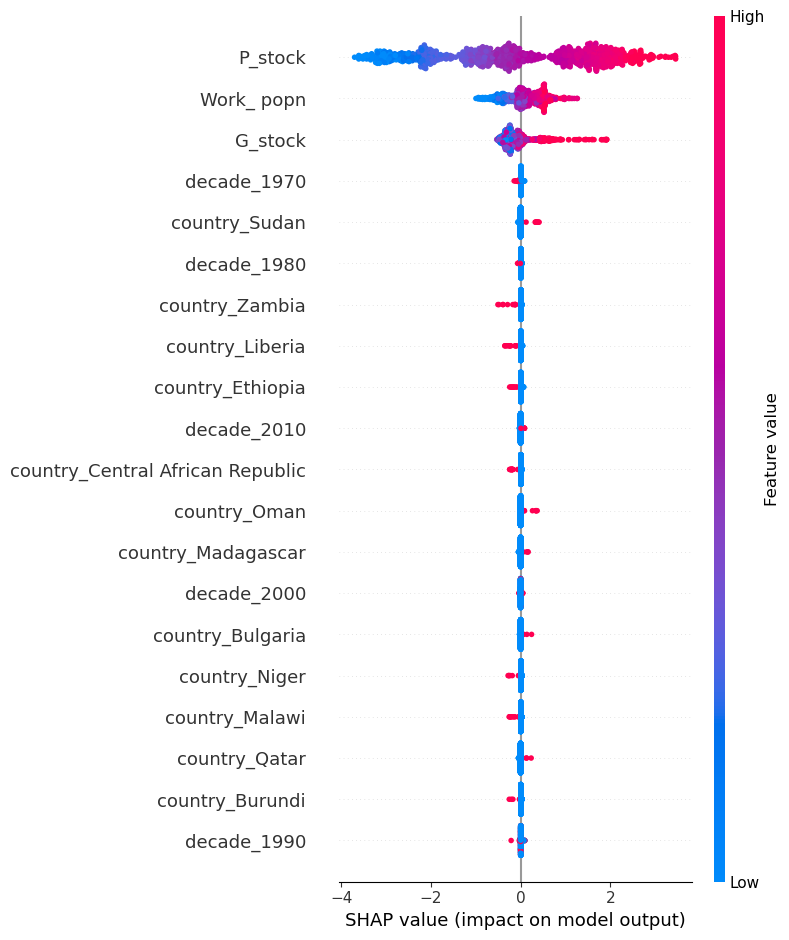

In [97]:
explainer = shap.TreeExplainer(rf_model)

# Compute SHAP values
shap_values = explainer.shap_values(X_test)

# SHAP values
shap.summary_plot(shap_values, X_test)



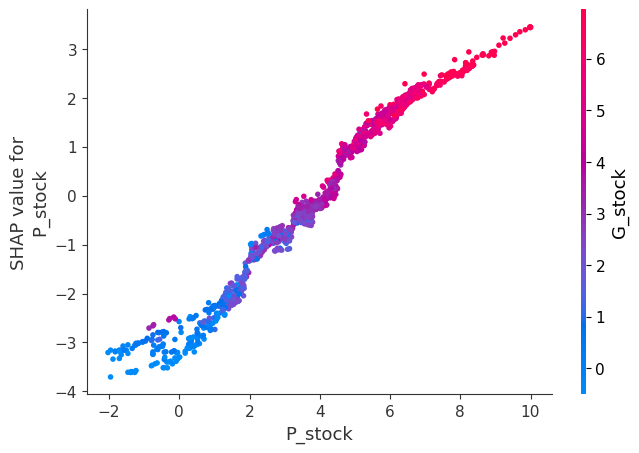

In [98]:
# SHAP dependence plot for interaction between P_stock and G_stock
shap.dependence_plot("P_stock", shap_values, X_test, interaction_index="G_stock")


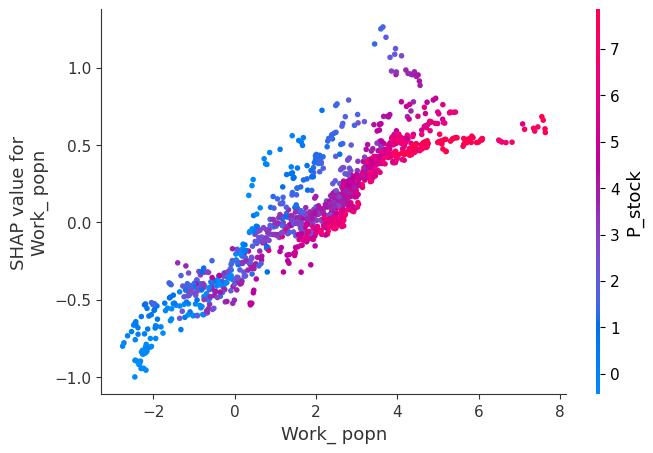

In [107]:
# SHAP dependence plot for interaction between work_popn and P_stock
shap.dependence_plot("Work_ popn", shap_values, X_test, interaction_index= "P_stock")

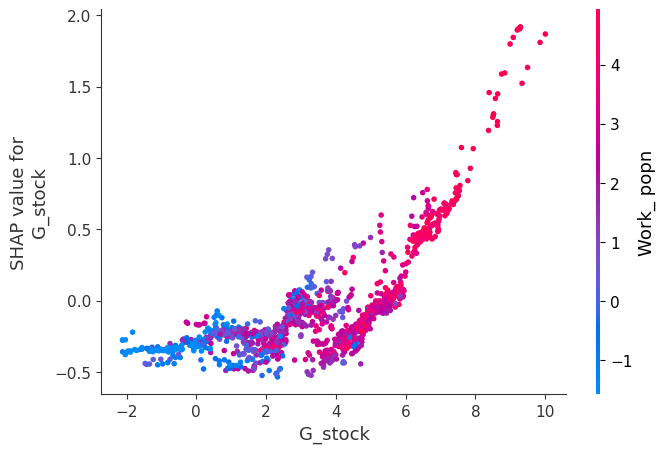

In [109]:
# SHAP dependence plot for interaction between G_stock and work_popn
shap.dependence_plot("G_stock", shap_values, X_test, interaction_index="Work_ popn")